# Homework 04: Building CNNs for Image Classification

## Due: Midnight on September 28 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects.

There are 10 graded questions, worth 8 points each, with 5 points free if you complete the homework.


## 1. Setup and Data Loading


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [3]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  



In [5]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [6]:
# Reproducible load + preprocess for Intel Image Classification

# -------------------------
# Loader (deterministic)
# -------------------------
def load_data_from_directory(directory, img_size=(150, 150), class_names=None):
    """
    Loads images as float32 in [0,1] and integer labels.
    Sorting ensures deterministic order. If class_names is provided,
    that ordering defines label indices.
    Returns: X, y, class_names_used
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # Ensure only classes present in directory are used (robustness)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        # Sort filenames so load order is reproducible
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            # Explicit interpolation for consistency
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img)  # float32
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = (np.array(X, dtype="float32") / 255.0)   # normalize to [0,1]
    y = np.array(y, dtype="int32")               # integer labels
    return X, y, class_names

def show_counts(name, y_arr):
    c = Counter(y_arr.tolist() if hasattr(y_arr, "tolist") else y_arr)
    print(f"{name} per-class counts:", dict(c))

# -------------------------
# Download & paths
# -------------------------
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

# -------------------------
# Load train (get class_names) & test using same mapping
# -------------------------
X_train_all, y_train_all, class_names = load_data_from_directory(train_dir, img_size=(150,150))
X_test,       y_test,   _            = load_data_from_directory(test_dir, img_size=(150,150), class_names=class_names)

num_classes = len(class_names)
print("class_names:", class_names)
print("X_train_all:", X_train_all.shape, "y_train_all:", y_train_all.shape)
print("X_test:     ", X_test.shape,      "y_test:     ", y_test.shape)

# -------------------------
# Stratified train/val split (reproducible)
# -------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True
)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train_all: (14034, 150, 150, 3) y_train_all: (14034,)
X_test:      (3000, 150, 150, 3) y_test:      (3000,)


### Examine The Dataset

In [7]:
print("X_train:",  X_train.shape,  "y_train:",  y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

X_train: (11227, 150, 150, 3) y_train: (11227,)
X_val: (2807, 150, 150, 3) y_val: (2807,)
train per-class counts: {0: 1753, 4: 1819, 2: 1923, 1: 1817, 5: 1906, 3: 2009}
val   per-class counts: {1: 454, 2: 481, 3: 503, 0: 438, 4: 455, 5: 476}
test  per-class counts: {0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


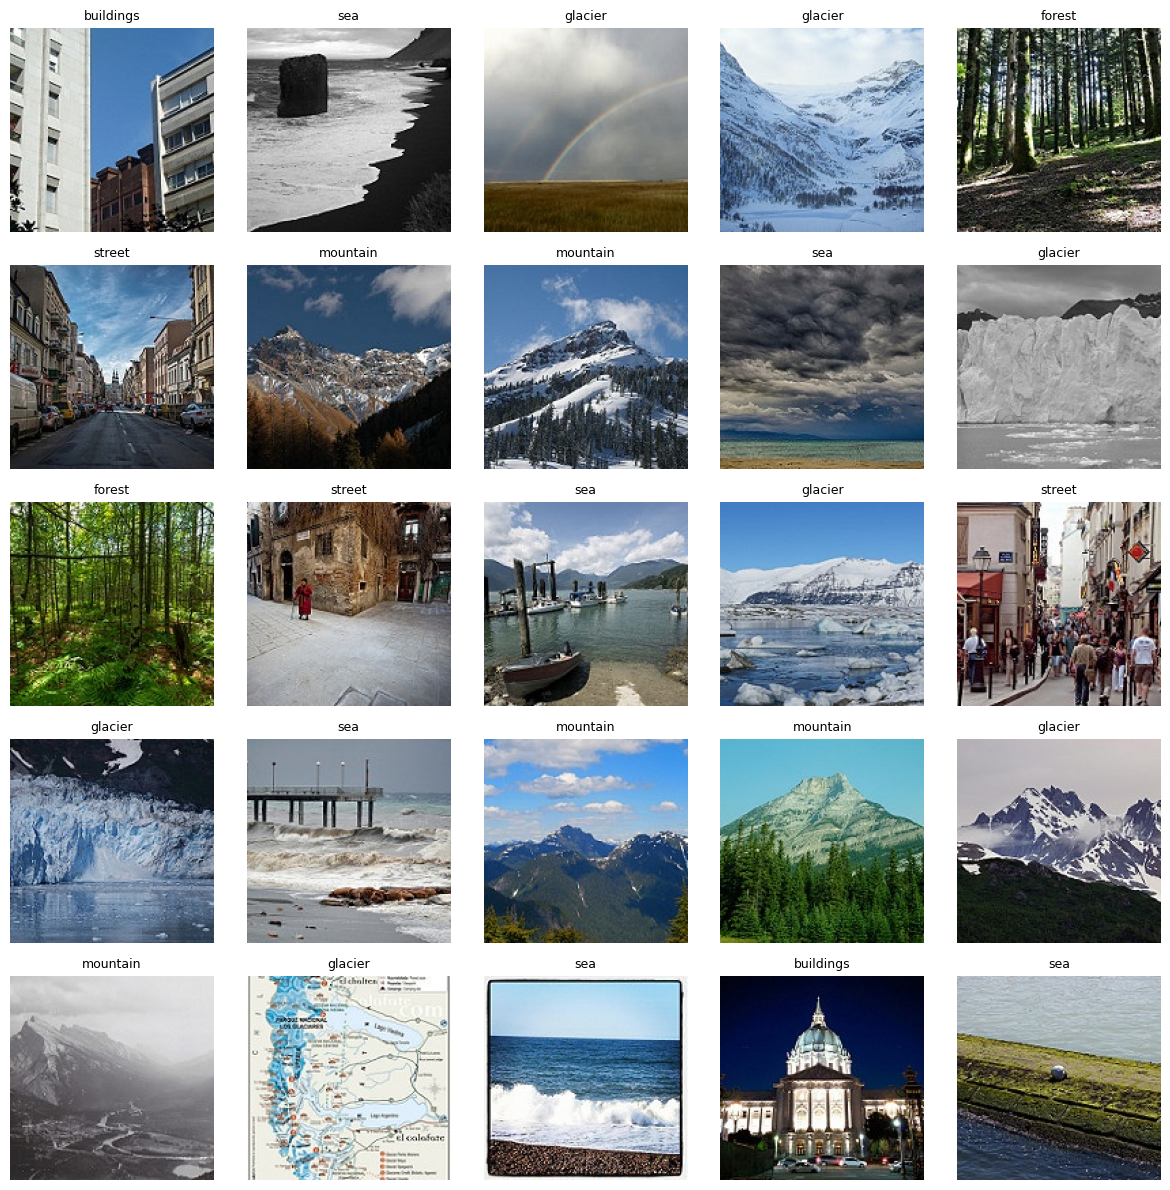

In [8]:
# Show a 5×5 grid of the first 25 training images
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[i])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!).

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in.



Baseline Model



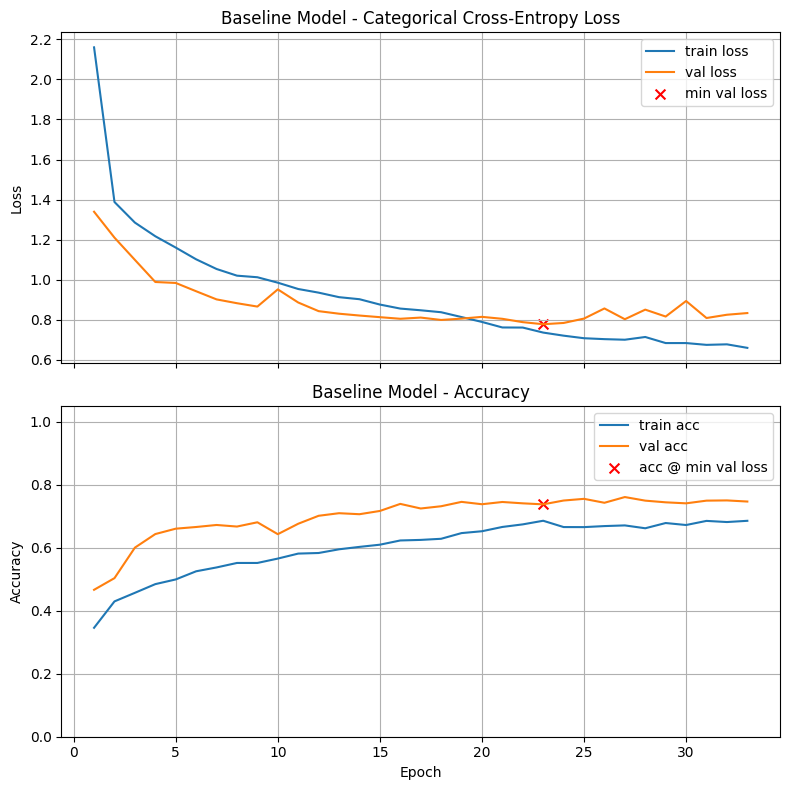

Final Training Loss:            0.6600
Final Training Accuracy:        0.6858
Final Validation Loss:          0.8337
Final Validation Accuracy:      0.7471
Minimum Validation Loss:        0.7779 (Epoch 23)
Validation Accuracy @ Min Loss: 0.7382

Test Loss: 0.7855
Test Accuracy: 0.7390

Validation-Test Gap (accuracy): 0.000845

Execution Time: 00:01:30


In [9]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title="Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer.
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5).


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).

=== Experiment 1: Lower Learning Rate ===

Problem 1 -- Tweak 1 -- lr: 0.0005



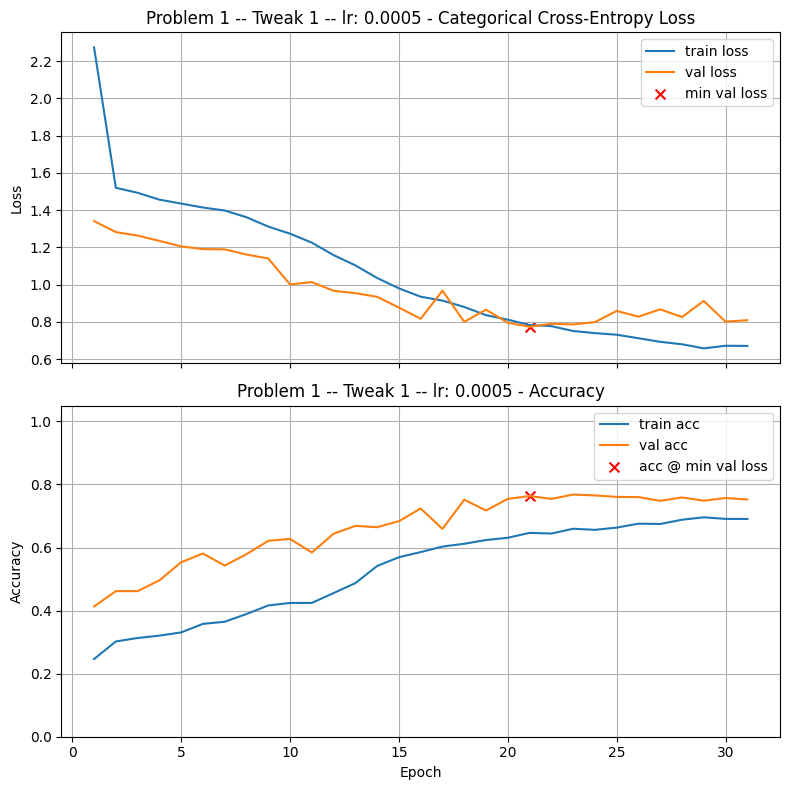

Final Training Loss:            0.6710
Final Training Accuracy:        0.6907
Final Validation Loss:          0.8091
Final Validation Accuracy:      0.7524
Minimum Validation Loss:        0.7737 (Epoch 21)
Validation Accuracy @ Min Loss: 0.7634

Test Loss: 0.7635
Test Accuracy: 0.7597

Validation-Test Gap (accuracy): 0.003782

Execution Time: 00:01:15

=== Experiment 2: Wider Conv2D Layers ===

Problem 1 -- Tweak 2 -- Conv Width: 64->128



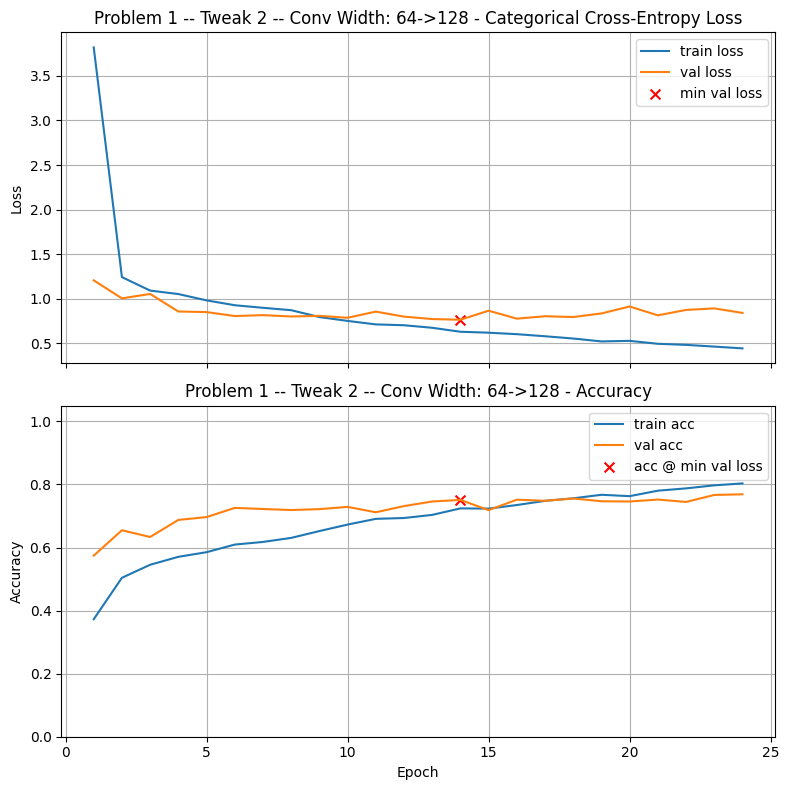

Final Training Loss:            0.4446
Final Training Accuracy:        0.8033
Final Validation Loss:          0.8421
Final Validation Accuracy:      0.7688
Minimum Validation Loss:        0.7655 (Epoch 14)
Validation Accuracy @ Min Loss: 0.7510

Test Loss: 0.7413
Test Accuracy: 0.7583

Validation-Test Gap (accuracy): 0.007354

Execution Time: 00:01:30

=== Experiment 3: Lower Dropout Rate ===

Problem 1 -- Tweak 3 -- Dropout: 0.2



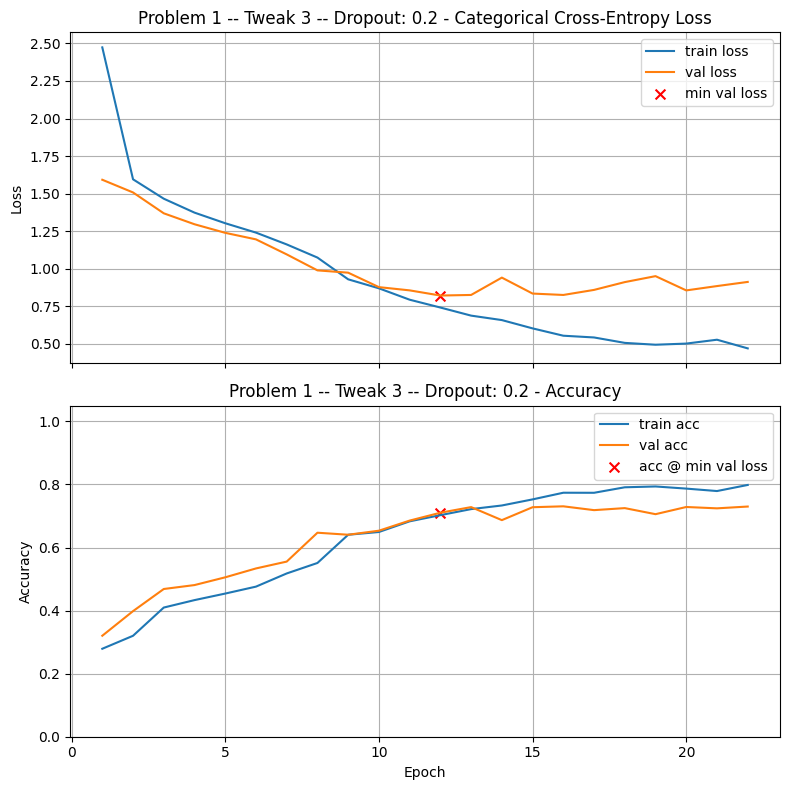

Final Training Loss:            0.4694
Final Training Accuracy:        0.7984
Final Validation Loss:          0.9119
Final Validation Accuracy:      0.7300
Minimum Validation Loss:        0.8213 (Epoch 12)
Validation Accuracy @ Min Loss: 0.7104

Test Loss: 0.8187
Test Accuracy: 0.7130

Validation-Test Gap (accuracy): 0.002633

Execution Time: 00:00:56


In [10]:
# Your code here, add additional cells if you wish

# Experiment 1: Adjust Learning Rate
print("=== Experiment 1: Lower Learning Rate ===")

he = initializers.HeNormal()

model_lr_low = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_lr_low,
               title="Problem 1 -- Tweak 1 -- lr: 0.0005",
               lr_schedule=0.0005)

# Experiment 2: Increase Conv2D Width
print("\n" + "="*50)
print("=== Experiment 2: Wider Conv2D Layers ===")

model_wider = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # 32->64
    MaxPooling2D(2),
    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"), # 64->128
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_wider,
               title="Problem 1 -- Tweak 2 -- Conv Width: 64->128")

# Experiment 3: Modify Dropout Rate
print("\n" + "="*50)
print("=== Experiment 3: Lower Dropout Rate ===")

model_dropout = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.2),  # Reduced from 0.5 to 0.2
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dropout,
               title="Problem 1 -- Tweak 3 -- Dropout: 0.2")

### Graded Questions

In [36]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 0             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [37]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 0


In [38]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a.

a1b = 0.7652             # Replace 0.0 with your answer

In [39]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7652


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence.

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.



=== Experiment 1: Baseline + Batch Normalization ===

Problem 2 -- Baseline + BatchNorm



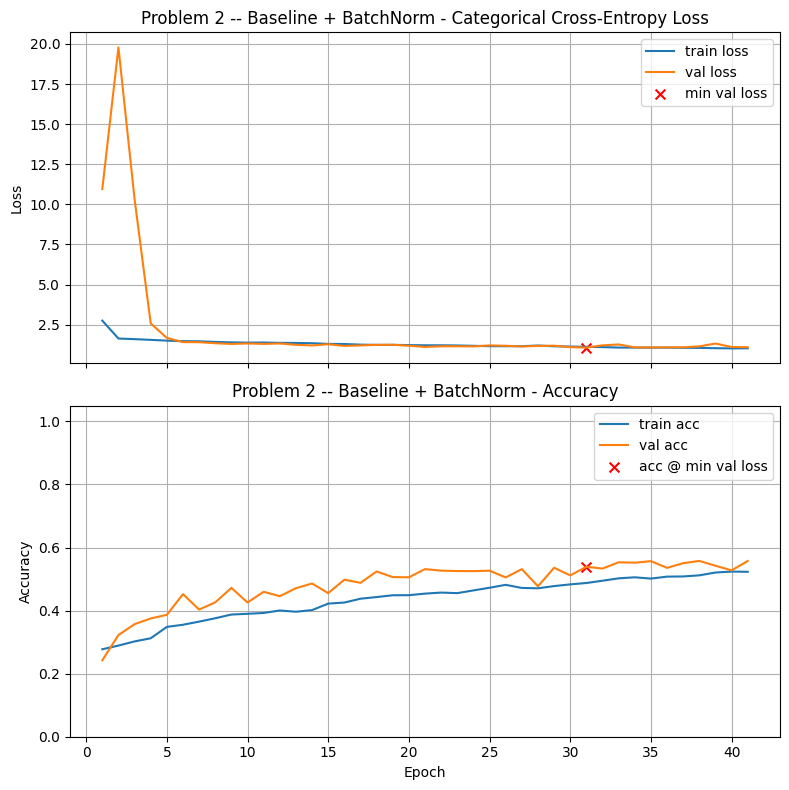

Final Training Loss:            1.0268
Final Training Accuracy:        0.5230
Final Validation Loss:          1.0941
Final Validation Accuracy:      0.5572
Minimum Validation Loss:        1.0695 (Epoch 31)
Validation Accuracy @ Min Loss: 0.5390

Test Loss: 1.0751
Test Accuracy: 0.5310

Validation-Test Gap (accuracy): 0.008010

Execution Time: 00:01:45

=== Experiment 2: BatchNorm + Lower Learning Rate ===

Problem 2 -- BatchNorm + lr: 0.0005



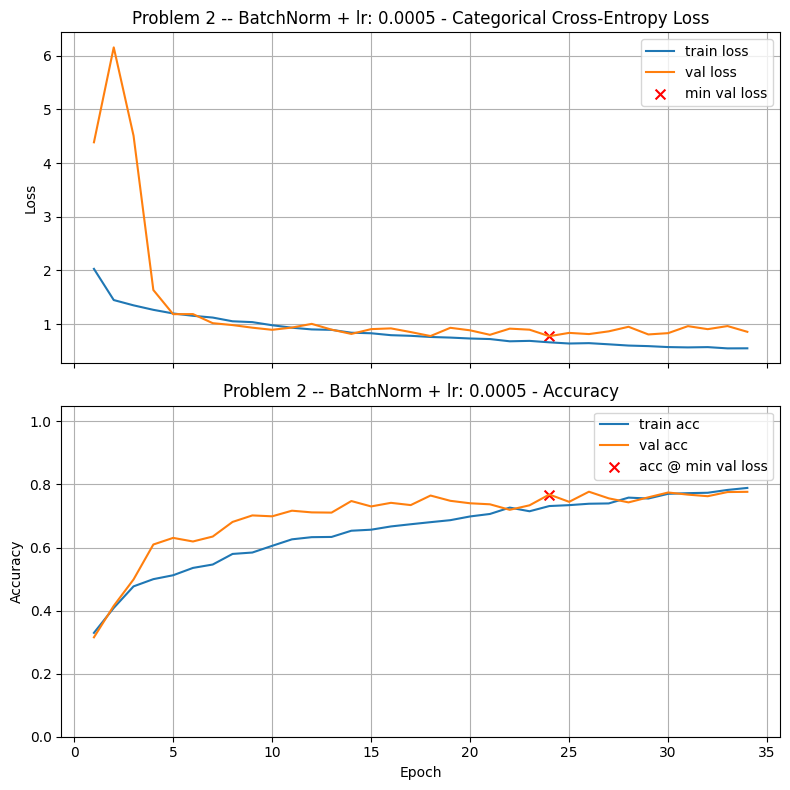

Final Training Loss:            0.5487
Final Training Accuracy:        0.7890
Final Validation Loss:          0.8561
Final Validation Accuracy:      0.7766
Minimum Validation Loss:        0.7747 (Epoch 24)
Validation Accuracy @ Min Loss: 0.7681

Test Loss: 0.7529
Test Accuracy: 0.7820

Validation-Test Gap (accuracy): 0.013920

Execution Time: 00:01:29


In [40]:
# Your code here, add additional cells if you wish

# Experiment 1: Baseline + Batch Normalization
print("=== Experiment 1: Baseline + Batch Normalization ===")

he = initializers.HeNormal()

model_baseline_bn = models.Sequential([
    Input(shape=X_train.shape[1:]),

    # First conv block with BatchNorm
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    # Second conv block with BatchNorm
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    # Classification head (unchanged)
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline_bn,
               title="Problem 2 -- Baseline + BatchNorm")

# Experiment 2: BatchNorm + Lower Learning Rate
print("\n" + "="*50)
print("=== Experiment 2: BatchNorm + Lower Learning Rate ===")

model_bn_lr = models.Sequential([
    Input(shape=X_train.shape[1:]),

    # First conv block with BatchNorm
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    # Second conv block with BatchNorm
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    # Classification head
    Flatten(),
    Dense(64, activation="relu", kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_bn_lr,
               title="Problem 2 -- BatchNorm + lr: 0.0005",
               lr_schedule=0.0005)

### Graded Questions

In [41]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 1             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [42]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')


a2a = 1


In [43]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem)

a2b = 0.7681             # Replace 0.0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7681


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video,
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique).

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block.

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.



=== Experiment 1: BatchNorm + GAP + lr: 0.0005 ===

Problem 3 -- BatchNorm + GAP + lr: 0.0005



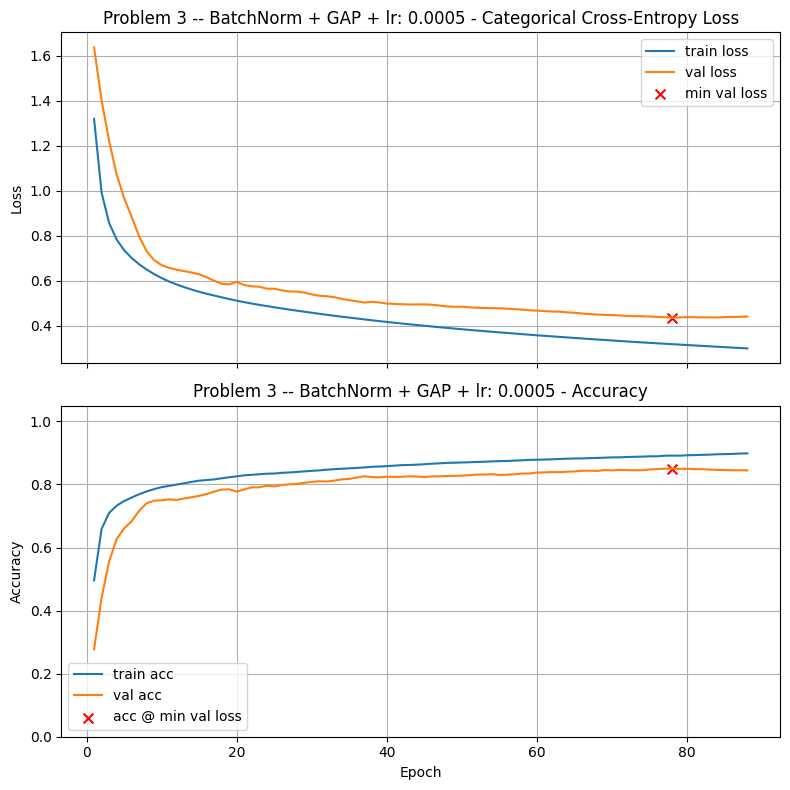

Final Training Loss:            0.2987
Final Training Accuracy:        0.8985
Final Validation Loss:          0.4403
Final Validation Accuracy:      0.8447
Minimum Validation Loss:        0.4357 (Epoch 78)
Validation Accuracy @ Min Loss: 0.8504

Test Loss: 0.4111
Test Accuracy: 0.8587

Validation-Test Gap (accuracy): 0.008293

Execution Time: 00:03:26

=== Experiment 2: GAP + Higher Learning Rate ===

Problem 3 -- GAP + lr: 0.001



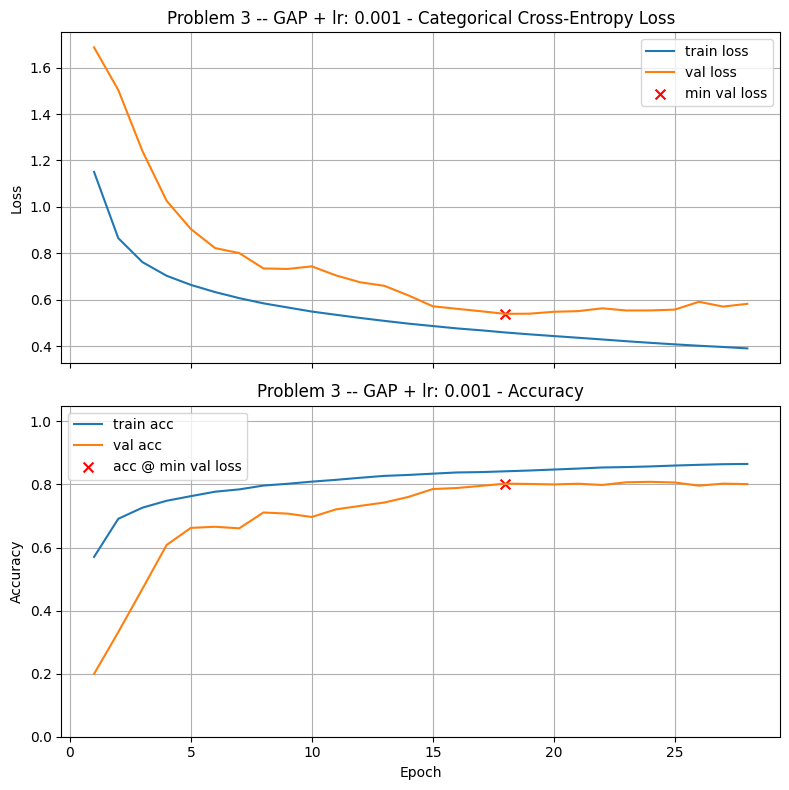

Final Training Loss:            0.3903
Final Training Accuracy:        0.8651
Final Validation Loss:          0.5824
Final Validation Accuracy:      0.8012
Minimum Validation Loss:        0.5389 (Epoch 18)
Validation Accuracy @ Min Loss: 0.8026

Test Loss: 0.5210
Test Accuracy: 0.8113

Validation-Test Gap (accuracy): 0.008697

Execution Time: 00:01:13

=== Experiment 3: GAP + Wider Conv Layers ===

Problem 3 -- GAP + Wider Conv + lr: 0.0005



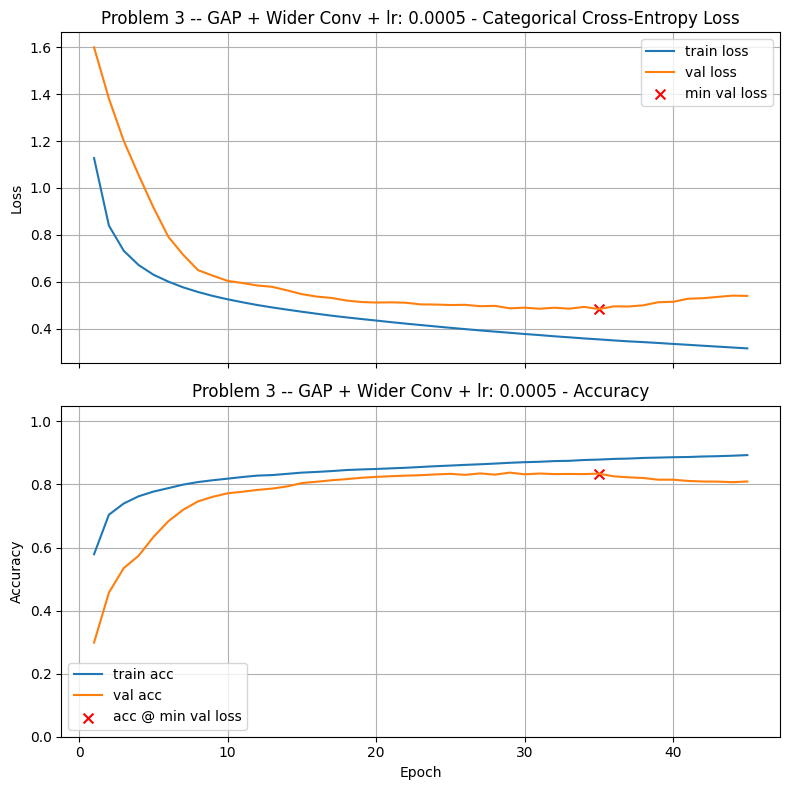

Final Training Loss:            0.3161
Final Training Accuracy:        0.8931
Final Validation Loss:          0.5399
Final Validation Accuracy:      0.8094
Minimum Validation Loss:        0.4836 (Epoch 35)
Validation Accuracy @ Min Loss: 0.8343

Test Loss: 0.4737
Test Accuracy: 0.8340

Validation-Test Gap (accuracy): 0.000343

Execution Time: 00:02:39


In [45]:
# Your code here, add additional cells if you wish

# Experiment 1: Best Model + Global Average Pooling
print("=== Experiment 1: BatchNorm + GAP + lr: 0.0005 ===")

he = initializers.HeNormal()

model_gap = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),

    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap,
               title="Problem 3 -- BatchNorm + GAP + lr: 0.0005",
               lr_schedule=0.0005)

# Experiment 2: GAP + Different Learning Rate
print("\n" + "="*50)
print("=== Experiment 2: GAP + Higher Learning Rate ===")

model_gap_lr = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_lr,
               title="Problem 3 -- GAP + lr: 0.001",
               lr_schedule=0.001)

# Experiment 3: GAP + Wider Conv Layers
print("\n" + "="*50)
print("=== Experiment 3: GAP + Wider Conv Layers ===")

model_gap_wide = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_wide,
               title="Problem 3 -- GAP + Wider Conv + lr: 0.0005",
               lr_schedule=0.0005)

### Graded Questions

In [46]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 1             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [47]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')


a3a = 1


In [48]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem)

a3b = 0.8504             # Replace 0.0 with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8504


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!).
* Answer the graded questions.



=== Experiment 1: GAP + ReduceLROnPlateau (factor=0.5, patience=3) ===

Problem 4 -- GAP + ReduceLR (factor=0.5, patience=3)


Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 125: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 148: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 152: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 156: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 160: ReduceLROnPlateau reducing learning rate to 1e-05.


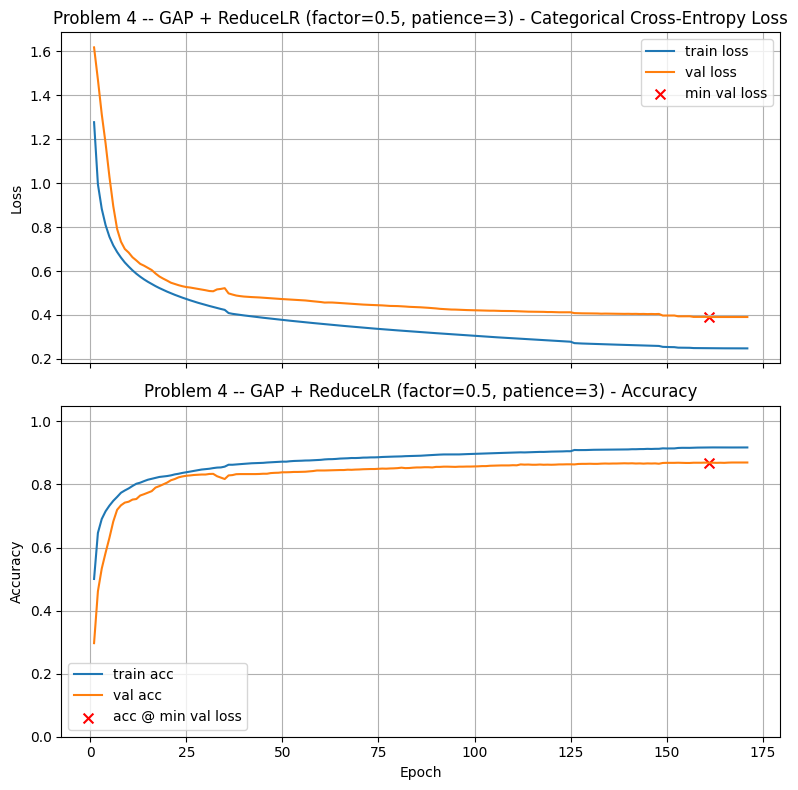

Final Training Loss:            0.2479
Final Training Accuracy:        0.9173
Final Validation Loss:          0.3907
Final Validation Accuracy:      0.8696
Minimum Validation Loss:        0.3907 (Epoch 161)
Validation Accuracy @ Min Loss: 0.8689

Test Loss: 0.3882
Test Accuracy: 0.8723

Validation-Test Gap (accuracy): 0.003434

Execution Time: 00:06:23

=== Experiment 2: More Aggressive LR Reduction ===

Problem 4 -- GAP + ReduceLR (factor=0.3, patience=3)


Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 147: ReduceLROnPlateau reducing learning rate to 4.500000213738531e-05.

Epoch 151: ReduceLROnPlateau reducing learning rate to 1.3500000204658135e-05.

Epoch 156: ReduceLROnPlateau reducing learning rate to 1e-05.


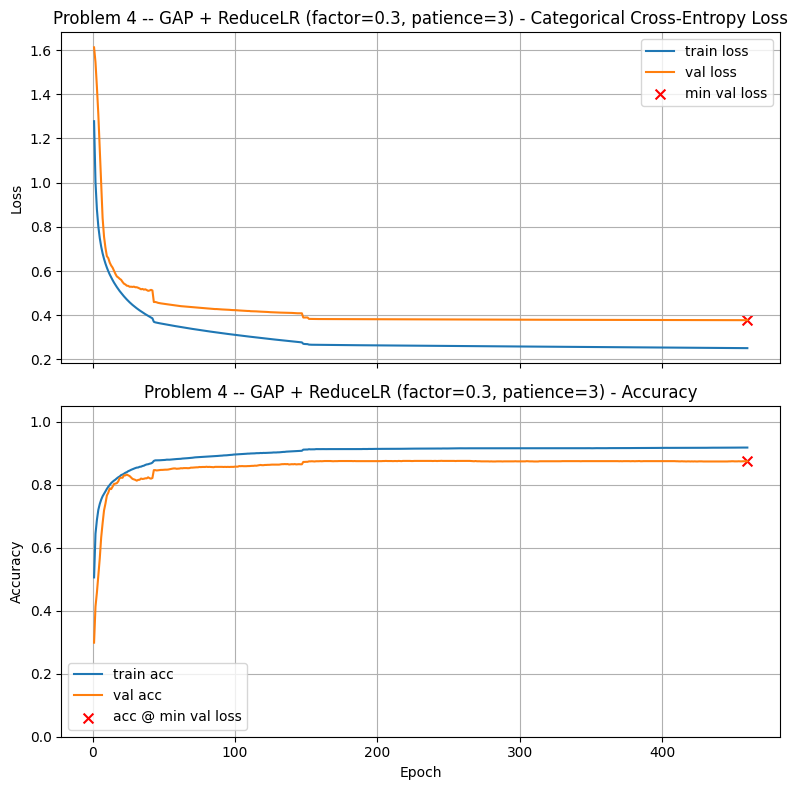

Final Training Loss:            0.2512
Final Training Accuracy:        0.9177
Final Validation Loss:          0.3778
Final Validation Accuracy:      0.8742
Minimum Validation Loss:        0.3778 (Epoch 460)
Validation Accuracy @ Min Loss: 0.8742

Test Loss: 0.3785
Test Accuracy: 0.8740

Validation-Test Gap (accuracy): 0.000243

Execution Time: 00:16:45

=== Experiment 3: Higher Patience ===

Problem 4 -- GAP + ReduceLR (factor=0.5, patience=5)


Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 144: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 150: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 166: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 172: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 178: ReduceLROnPlateau reducing learning rate to 1e-05.


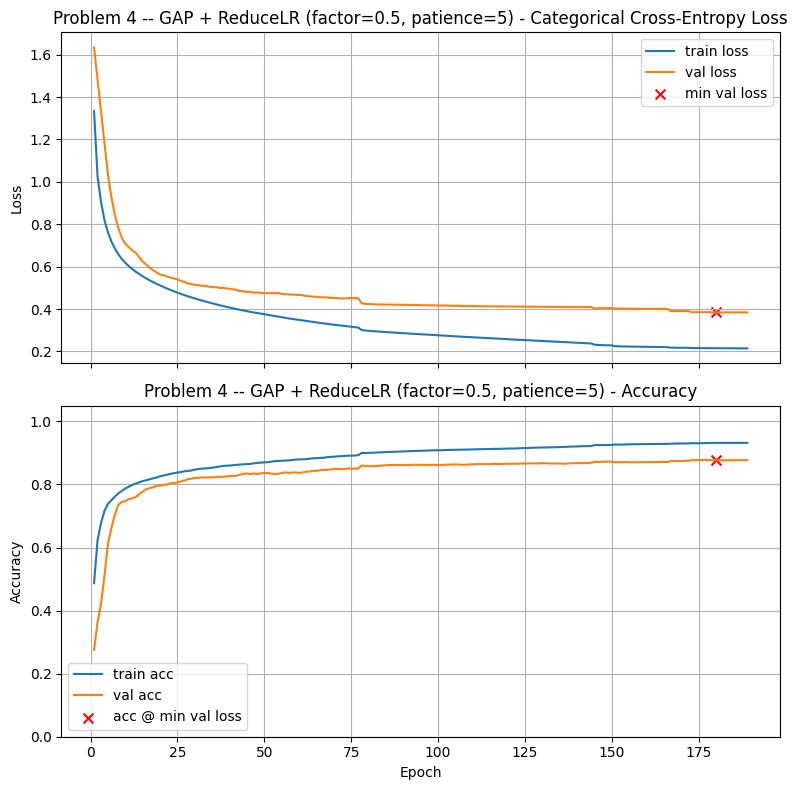

Final Training Loss:            0.2144
Final Training Accuracy:        0.9320
Final Validation Loss:          0.3842
Final Validation Accuracy:      0.8771
Minimum Validation Loss:        0.3841 (Epoch 180)
Validation Accuracy @ Min Loss: 0.8767

Test Loss: 0.3868
Test Accuracy: 0.8747

Validation-Test Gap (accuracy): 0.002426

Execution Time: 00:07:00

=== Experiment 4: Higher min_delta Threshold ===

Problem 4 -- GAP + ReduceLR (min_delta=1e-3)


Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 92: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 96: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 100: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 104: ReduceLROnPlateau reducing learning rate to 1e-05.


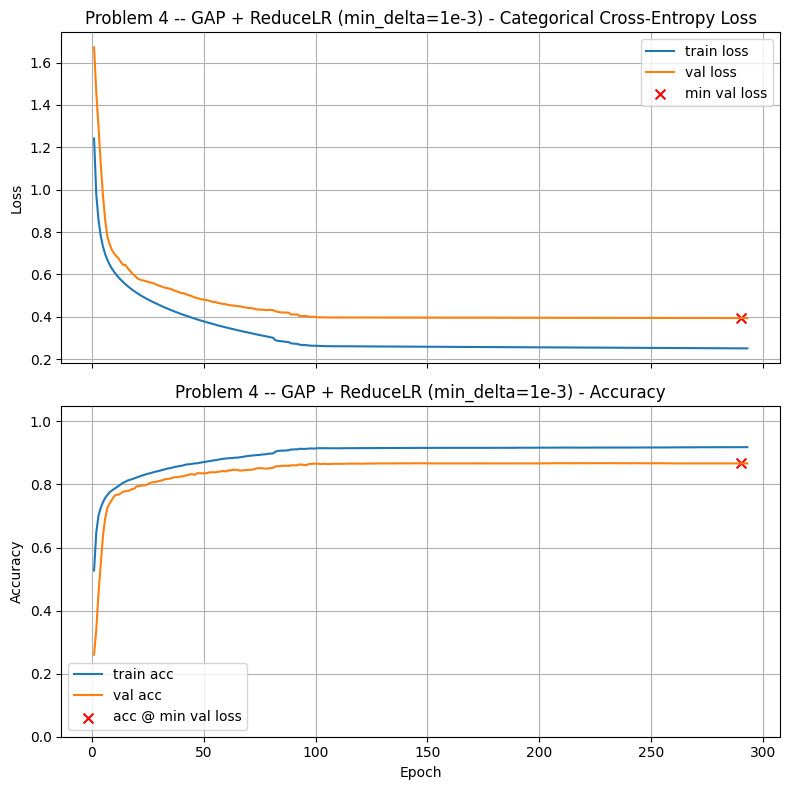

Final Training Loss:            0.2508
Final Training Accuracy:        0.9182
Final Validation Loss:          0.3939
Final Validation Accuracy:      0.8668
Minimum Validation Loss:        0.3939 (Epoch 290)
Validation Accuracy @ Min Loss: 0.8668

Test Loss: 0.3899
Test Accuracy: 0.8777

Validation-Test Gap (accuracy): 0.010905

Execution Time: 00:10:42


In [51]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

# Experiment 1: Best Model + ReduceLROnPlateau (Default)
print("=== Experiment 1: GAP + ReduceLROnPlateau (factor=0.5, patience=3) ===")

he = initializers.HeNormal()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-5,
    verbose=1
)

model_reduce_lr = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reduce_lr,
               title="Problem 4 -- GAP + ReduceLR (factor=0.5, patience=3)",
               lr_schedule=0.0005,
               callbacks=[reduce_lr])

# Experiment 2: More Aggressive Reduction (factor=0.3)
print("\n" + "="*50)
print("=== Experiment 2: More Aggressive LR Reduction ===")

reduce_lr_aggressive = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-5,
    verbose=1
)

model_reduce_lr_agg = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reduce_lr_agg,
               title="Problem 4 -- GAP + ReduceLR (factor=0.3, patience=3)",
               lr_schedule=0.0005,
               callbacks=[reduce_lr_aggressive])

# Experiment 3: Higher Patience (patience=5)
print("\n" + "="*50)
print("=== Experiment 3: Higher Patience ===")

reduce_lr_patient = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_delta=1e-4,
    cooldown=1,
    min_lr=1e-5,
    verbose=1
)

model_reduce_lr_patient = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reduce_lr_patient,
               title="Problem 4 -- GAP + ReduceLR (factor=0.5, patience=5)",
               lr_schedule=0.0005,
               callbacks=[reduce_lr_patient])

# Experiment 4: Different min_delta (1e-3)
print("\n" + "="*50)
print("=== Experiment 4: Higher min_delta Threshold ===")

reduce_lr_threshold = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_delta=1e-3,
    cooldown=1,
    min_lr=1e-5,
    verbose=1
)

model_reduce_lr_thresh = models.Sequential([
    Input(shape=X_train.shape[1:]),
    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),
    GlobalAveragePooling2D(),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_reduce_lr_thresh,
               title="Problem 4 -- GAP + ReduceLR (min_delta=1e-3)",
               lr_schedule=0.0005,
               callbacks=[reduce_lr_threshold])

### Graded Questions

In [56]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.5             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [57]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.2f}')

a4a = 0.50


In [58]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem)

a4b = 0.8767             # Replace 0.0 with your answer

In [59]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8767


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see:

        https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

![Screenshot 2025-09-19 at 6.50.24 AM.png](attachment:62fa0824-bb06-4663-a6a5-da8cca8f4ab3.png)


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss**
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect.




VGG-style Large



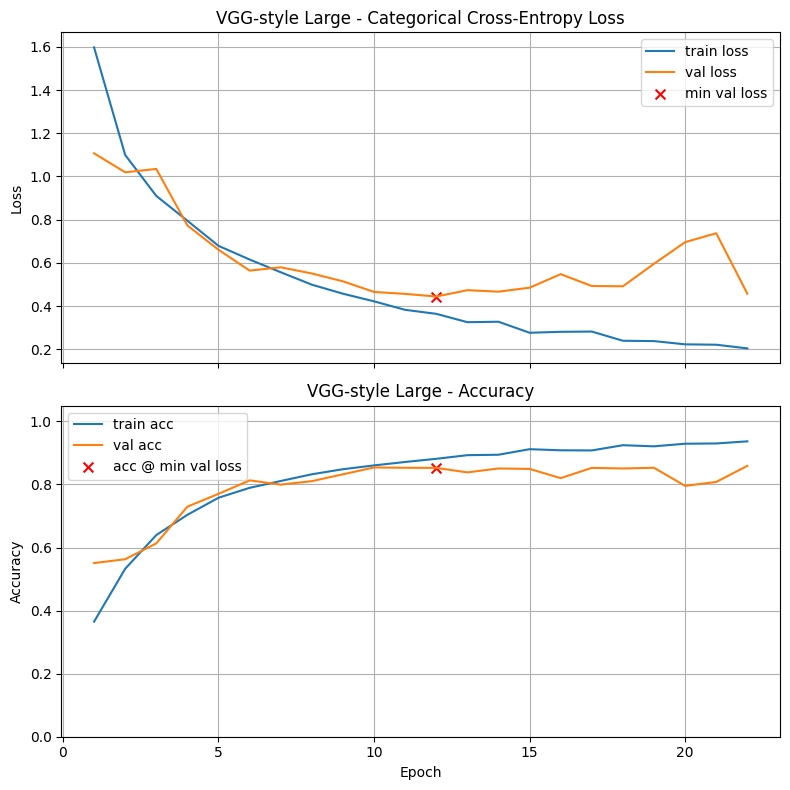

Final Training Loss:            0.2041
Final Training Accuracy:        0.9368
Final Validation Loss:          0.4574
Final Validation Accuracy:      0.8589
Minimum Validation Loss:        0.4441 (Epoch 12)
Validation Accuracy @ Min Loss: 0.8525

Test Loss: 0.4408
Test Accuracy: 0.8477

Validation-Test Gap (accuracy): 0.004845

Execution Time: 00:04:12


In [60]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

train_and_test(model_vgg_16,lr_schedule=1e-3,title="VGG-style Large")


VGG-16 LEARNING RATE SWEEP

Testing Learning Rate: 0.01

VGG-16 -- LR: 0.01



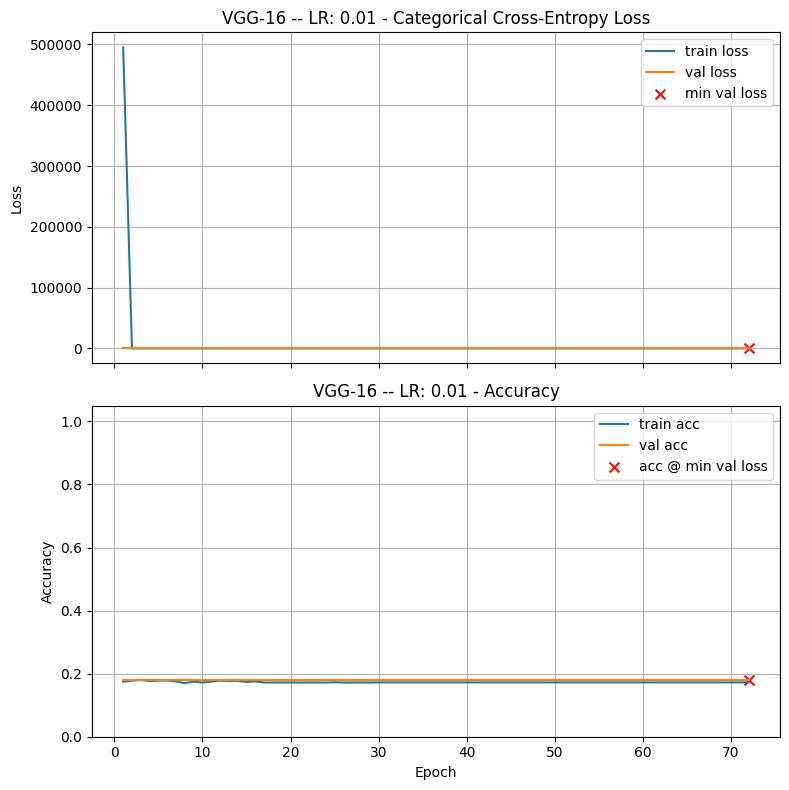

Final Training Loss:            1.8078
Final Training Accuracy:        0.1724
Final Validation Loss:          1.8072
Final Validation Accuracy:      0.1792
Minimum Validation Loss:        1.8072 (Epoch 72)
Validation Accuracy @ Min Loss: 0.1792

Test Loss: 1.8070
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004195

Execution Time: 00:09:57
Completed LR: 0.01

Testing Learning Rate: 0.003

VGG-16 -- LR: 0.003



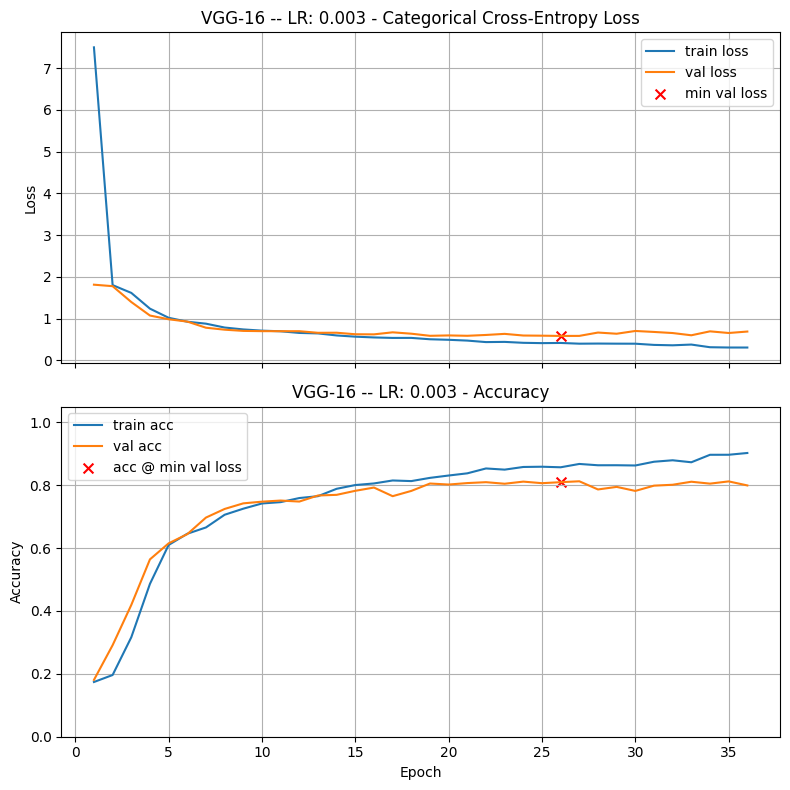

Final Training Loss:            0.3069
Final Training Accuracy:        0.9022
Final Validation Loss:          0.6897
Final Validation Accuracy:      0.7991
Minimum Validation Loss:        0.5845 (Epoch 26)
Validation Accuracy @ Min Loss: 0.8094

Test Loss: 0.5576
Test Accuracy: 0.8153

Validation-Test Gap (accuracy): 0.005928

Execution Time: 00:05:10
Completed LR: 0.003

Testing Learning Rate: 0.0003

VGG-16 -- LR: 0.0003



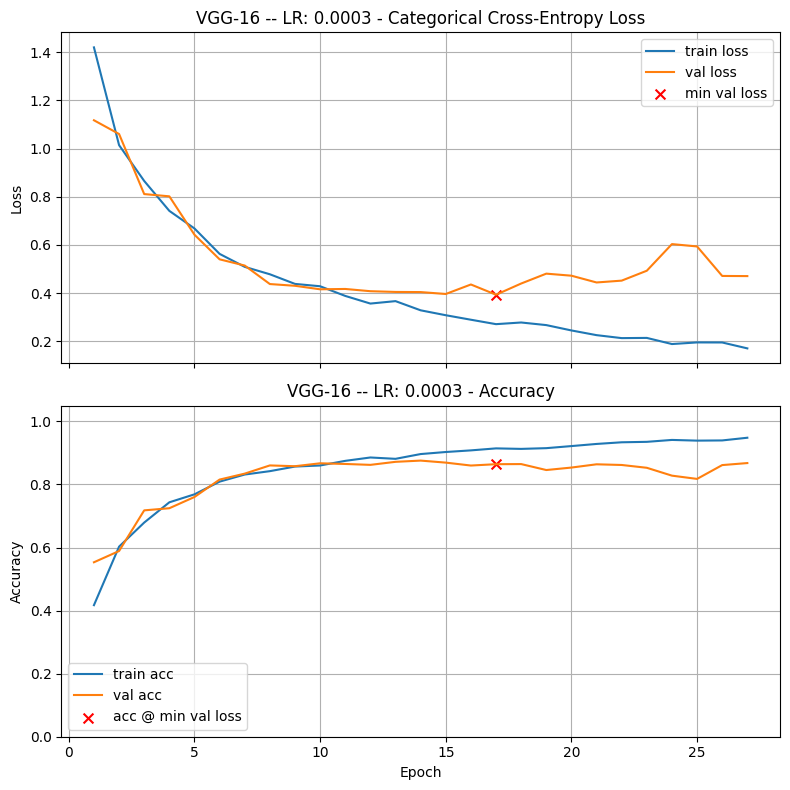

Final Training Loss:            0.1700
Final Training Accuracy:        0.9482
Final Validation Loss:          0.4703
Final Validation Accuracy:      0.8678
Minimum Validation Loss:        0.3930 (Epoch 17)
Validation Accuracy @ Min Loss: 0.8643

Test Loss: 0.4014
Test Accuracy: 0.8687

Validation-Test Gap (accuracy): 0.004399

Execution Time: 00:04:01
Completed LR: 0.0003

Testing Learning Rate: 0.0001

VGG-16 -- LR: 0.0001



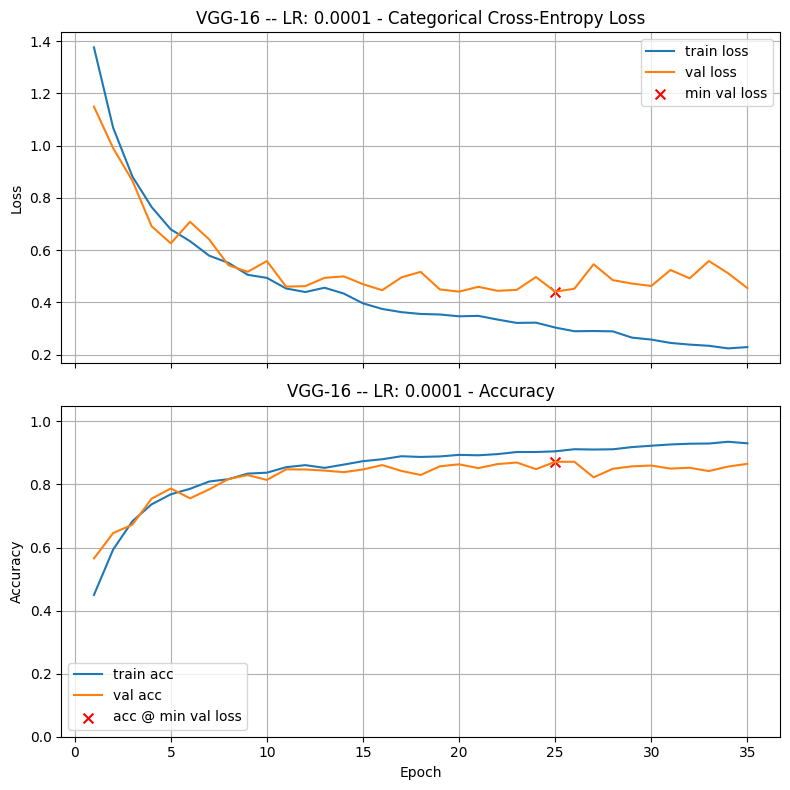

Final Training Loss:            0.2293
Final Training Accuracy:        0.9305
Final Validation Loss:          0.4552
Final Validation Accuracy:      0.8653
Minimum Validation Loss:        0.4414 (Epoch 25)
Validation Accuracy @ Min Loss: 0.8717

Test Loss: 0.4240
Test Accuracy: 0.8693

Validation-Test Gap (accuracy): 0.002416

Execution Time: 00:05:07
Completed LR: 0.0001

Testing Learning Rate: 3e-05

VGG-16 -- LR: 3e-05



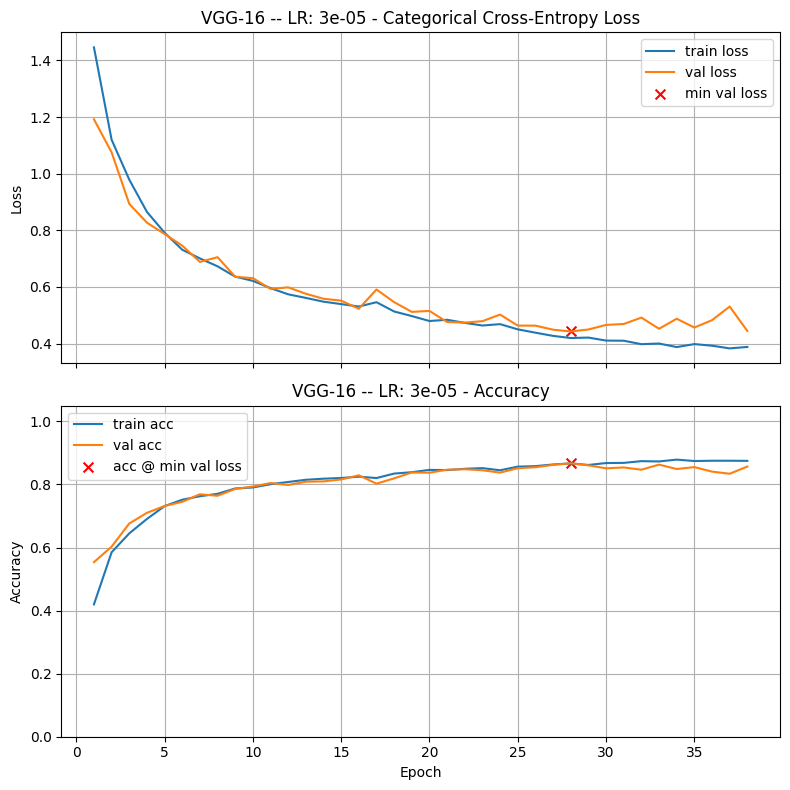

Final Training Loss:            0.3884
Final Training Accuracy:        0.8749
Final Validation Loss:          0.4448
Final Validation Accuracy:      0.8568
Minimum Validation Loss:        0.4430 (Epoch 28)
Validation Accuracy @ Min Loss: 0.8671

Test Loss: 0.4497
Test Accuracy: 0.8617

Validation-Test Gap (accuracy): 0.005451

Execution Time: 00:05:33
Completed LR: 3e-05

Testing Learning Rate: 1e-05

VGG-16 -- LR: 1e-05



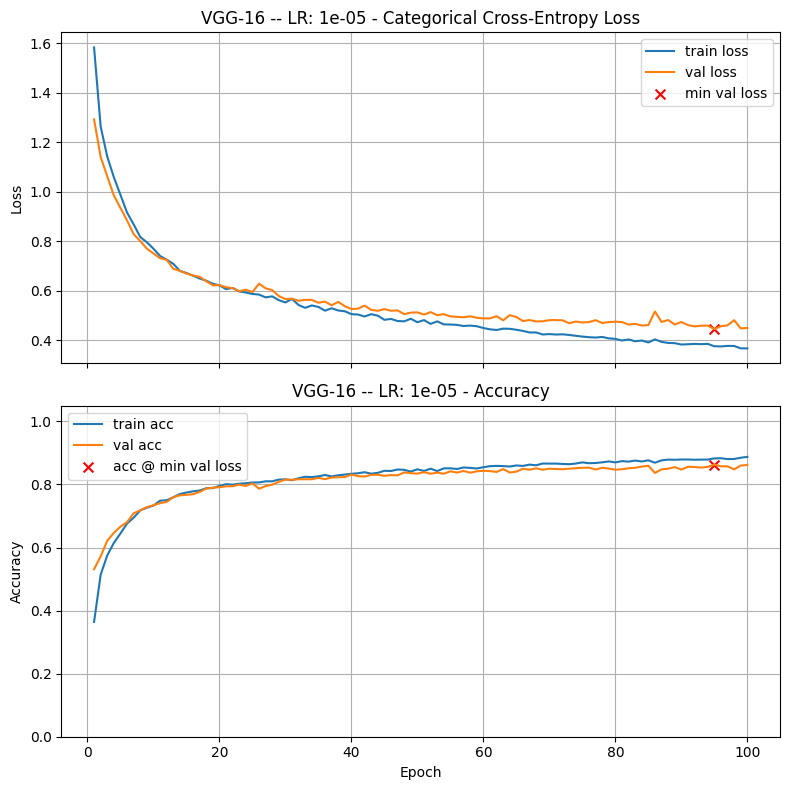

Final Training Loss:            0.3673
Final Training Accuracy:        0.8874
Final Validation Loss:          0.4499
Final Validation Accuracy:      0.8618
Minimum Validation Loss:        0.4452 (Epoch 95)
Validation Accuracy @ Min Loss: 0.8628

Test Loss: 0.4426
Test Accuracy: 0.8630

Validation-Test Gap (accuracy): 0.000157

Execution Time: 00:13:59
Completed LR: 1e-05

LEARNING RATE SWEEP COMPLETE
Use print_results() to see ranking!


In [61]:
# Problem 5: VGG-16 Learning Rate Sweep

he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

def create_vgg16_model():
    """Create VGG-16 style model (same architecture each time)"""
    return models.Sequential([
        layers.Input(shape=(150, 150, 3)),

        # Block 1
        layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.MaxPooling2D(),

        # Block 4 (NO MaxPool here -> leaves 3×3×512)
        layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
        layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

        # Global pooling meaningfully summarizes the 3×3 map
        layers.GlobalAveragePooling2D(),

        # Compact head
        layers.Dense(256, activation='relu', kernel_initializer=he,
                     kernel_regularizer=l2reg),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

learning_rates = [1e-2, 3e-3, 3e-4, 1e-4, 3e-5, 1e-5]  # Skipped 1e-3 since it was already tested

print("="*60)
print("VGG-16 LEARNING RATE SWEEP")
print("="*60)

for lr in learning_rates:
    print(f"\n{'='*50}")
    print(f"Testing Learning Rate: {lr}")
    print(f"{'='*50}")

    model_vgg = create_vgg16_model()

    train_and_test(model_vgg,
                   lr_schedule=lr,
                   title=f"VGG-16 -- LR: {lr}",
                   epochs=100,
                   verbose=0)

    print(f"Completed LR: {lr}")

print("\n" + "="*60)
print("LEARNING RATE SWEEP COMPLETE")
print("="*60)
print("Use print_results() to see ranking!")

### Graded Questions

In [62]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 1e-4             # Replace with your best learning rate

In [64]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.8f}')

a5a = 0.00010000


In [65]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem)

a5b = 0.8717              # Replace 0.0 with your answer

In [66]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8717


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [67]:
print_results()

Problem 4 -- GAP + ReduceLR (factor=0.5, patience=5)	0.8767	180
Problem 4 -- GAP + ReduceLR (factor=0.3, patience=3)	0.8742	460
VGG-16 -- LR: 0.0001                    	0.8717	25
Problem 4 -- GAP + ReduceLR (factor=0.5, patience=3)	0.8689	161
VGG-16 -- LR: 3e-05                     	0.8671	28
Problem 4 -- GAP + ReduceLR (min_delta=1e-3)	0.8668	290
VGG-16 -- LR: 0.0003                    	0.8643	17
VGG-16 -- LR: 1e-05                     	0.8628	95
VGG-style Large                         	0.8525	12
Problem 3 -- BatchNorm + GAP + lr: 0.0005	0.8504	78
Problem 3 -- GAP + Wider Conv + lr: 0.0005	0.8343	35
VGG-16 -- LR: 0.003                     	0.8094	26
Problem 3 -- GAP + lr: 0.001            	0.8026	18
Problem 2 -- BatchNorm + lr: 0.0005     	0.7681	24
Problem 1 -- Tweak 1 -- lr: 0.0005      	0.7634	21
Problem 1 -- Tweak 2 -- Conv Width: 64->128	0.7510	14
Baseline Model                          	0.7382	23
Problem 1 -- Tweak 3 -- Dropout: 0.2    	0.7104	12
Problem 2 -- Baseline + BatchNor